In [349]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image, ImageOps, ImageFilter, ImageEnhance
from tqdm import tqdm
import math


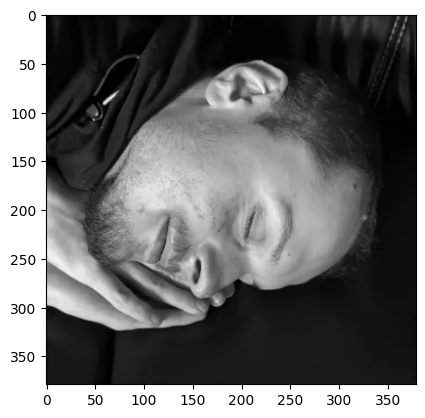

In [350]:
img = cv2.imread("../dlaza.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_16 = img.astype(np.int16)
canvas = np.full_like(img, 255)
canvas[0, 0] = 0
canvas[0, 1] = 255

imshow(img, cmap="gray")


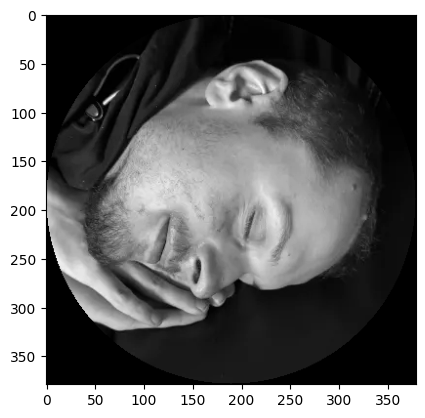

In [351]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None:  # use the middle of the image
        center = (int(w / 2), int(h / 2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w - center[0], h - center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)

    mask = dist_from_center <= radius
    return mask


# preprocess
mask = create_circular_mask(img.shape[0], img.shape[1])
imgcircle = img.copy()
imgcircle[~mask] = 0
img = imgcircle


imshow(imgcircle, cmap="gray")


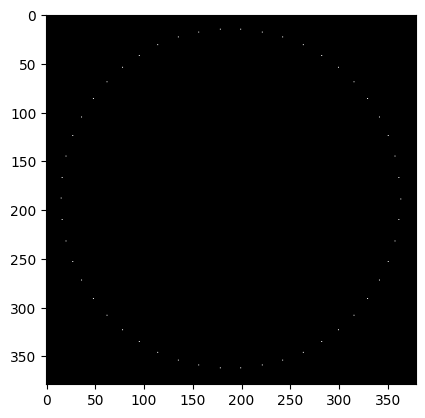

In [352]:
def generate_circle_points(center, radius, n):
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    points = [
        (center[0] + radius * np.cos(angle), center[1] + radius * np.sin(angle))
        for angle in angles
    ]
    return points


center = (img.shape[0] // 2, img.shape[1] // 2)
radius = min(img.shape) // 2 - 15
n = 50
circle_points = generate_circle_points(center, radius, n)

# Plot the points on the image
img_gray = np.full_like(img, 0)
for point in circle_points:
    img_gray[int(point[1]), int(point[0])] = 255

imshow(img_gray, cmap="gray")

spagat = [0]


In [353]:
start = 0
spagat = [start]
cary = {}
for x in range(n):
    for y in range(n):
        cary[(x, y)] = 0


100%|██████████| 1000/1000 [00:06<00:00, 148.35it/s]


255 0


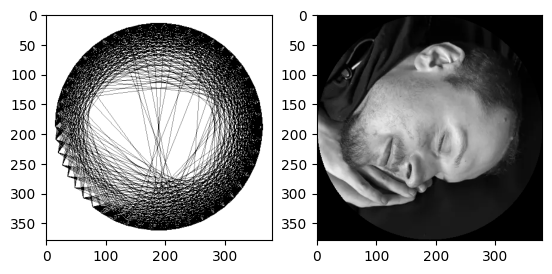

In [354]:
for _ in tqdm(range(1_000)):
    from_pos = circle_points[start]
    best = [-1, math.inf]
    for indx, pos in enumerate(circle_points):
        if indx == start:
            continue

        if cary[(start, indx)] == 5:
            continue
        # print(cary[(start, indx)])

        canvas_w_line = cv2.line(
            # np.full_like(canvas, 255, dtype=np.int16),
            canvas.copy().astype(np.int16),
            tuple(map(int, from_pos)),
            tuple(map(int, pos)),
            0,
            1,
        )

        # error_img = cv2.subtract(canvas_w_line, canvas_w_line)
        error_img = np.abs(canvas_w_line - img)
        error = np.sum(error_img)

        if error < best[1]:
            best = [indx, error]

    canvas_w_line = cv2.line(
        np.full_like(canvas, 0),
        tuple(map(int, from_pos)),
        tuple(map(int, circle_points[best[0]])),
        127,
        1,
    )

    canvas = cv2.subtract(canvas, canvas_w_line)

    # print(best, startcanvas)
    cary[(start, best[0])] += 1
    spagat.append(best[0])
    start = best[0]

plt.subplot(1, 2, 1)
imshow(canvas, cmap="gray")
plt.subplot(1, 2, 2)
imshow(img, cmap="gray")

print(canvas.max(), canvas.min())
